In [90]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [91]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
np.random.seed(0)

In [93]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train,y_train = train_data['features'],train_data['labels']
X_val,y_val = val_data['features'],val_data['labels']
X_test,y_test = test_data['features'],test_data['labels']

<class 'dict'>


In [94]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0]==y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0]==y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:]==(32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:]==(32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:]==(32,32,3)), "The dimensions of the images are not 32x32x3"

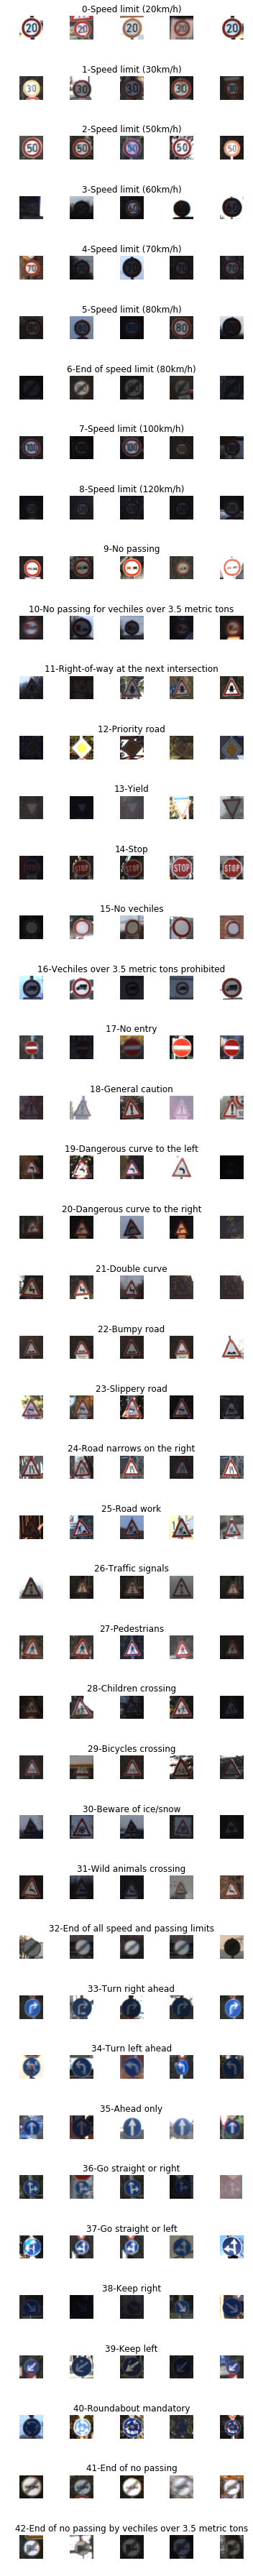

In [96]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig,axs = plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j,row in data.iterrows():
    x_selected = X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)),:,:],cmap=plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i == 2:
      axs[j][i].set_title(str(j) + '-' + row['SignName'])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


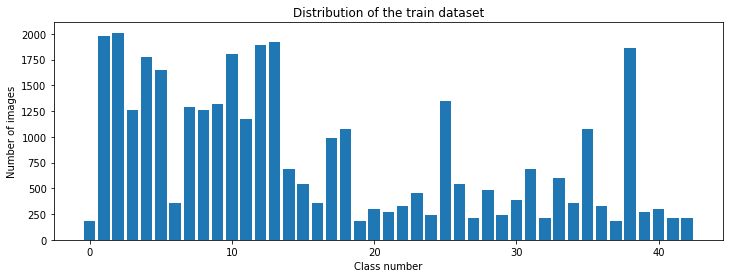

In [97]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title('Distribution of the train dataset')
plt.xlabel('Class number')
plt.ylabel('Number of images')
plt.show()

(32, 32, 3)
36


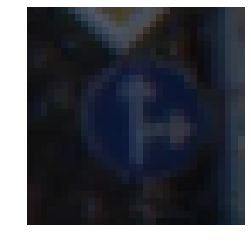

In [98]:
import cv2

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [0]:
def grayscale(img):
  return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

(-0.5, 31.5, 31.5, -0.5)

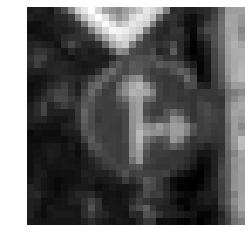

In [100]:
img = grayscale(X_train[1000])
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')

In [0]:
def equalize(img):
  return cv2.equalizeHist(img)

(32, 32)


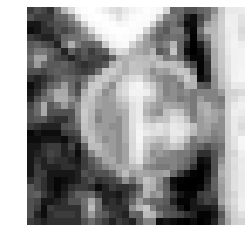

In [102]:
img = equalize(img)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

In [0]:
def preprocess(img):
  return equalize(grayscale(img))/255

In [0]:
X_train = np.array(list(map(preprocess,X_train)))
X_val = np.array(list(map(preprocess,X_val)))
X_test = np.array(list(map(preprocess,X_test)))

(34799, 32, 32)


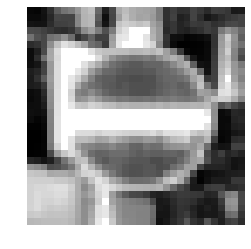

In [105]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)],cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799,32,32,1)
X_val = X_val.reshape(4410,32,32,1)
X_test = X_test.reshape(12630,32,32,1)

In [107]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                  height_shift_range=0.1,
                  zoom_range=0.2,
                  shear_range=0.1,
                  rotation_range=10)
datagen.fit(X_train)

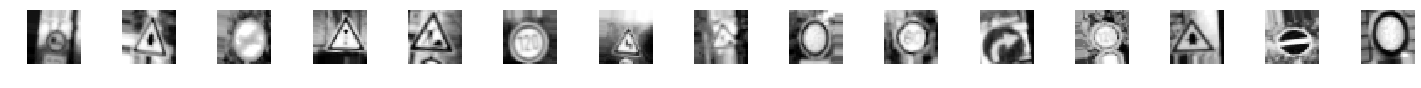

In [109]:
batches = datagen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)

fig,axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32),cmap=plt.get_cmap('gray'))
  axs[i].axis('off')

In [0]:
y_train = to_categorical(y_train,43)
y_val = to_categorical(y_val,43)
y_test = to_categorical(y_test,43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [112]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)               0         
__________

In [113]:
history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch=2000,epochs=10,validation_data=[X_val,y_val],shuffle=True)

Epoch 1/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.8672 - acc: 0.7465 - val_loss: 0.0753 - val_acc: 0.9771
Epoch 2/10
2000/2000 [==============================] - 35s 18ms/step - loss: 0.2048 - acc: 0.9355 - val_loss: 0.0838 - val_acc: 0.9705
Epoch 3/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1375 - acc: 0.9573 - val_loss: 0.0487 - val_acc: 0.9866
Epoch 4/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1097 - acc: 0.9657 - val_loss: 0.0233 - val_acc: 0.9939
Epoch 5/10
2000/2000 [==============================] - 35s 17ms/step - loss: 0.0896 - acc: 0.9726 - val_loss: 0.0284 - val_acc: 0.9925
Epoch 6/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.0782 - acc: 0.9757 - val_loss: 0.0494 - val_acc: 0.9841
Epoch 7/10
2000/2000 [==============================] - 35s 18ms/step - loss: 0.0709 - acc: 0.9780 - val_loss: 0.0281 - val_acc: 0.9927
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

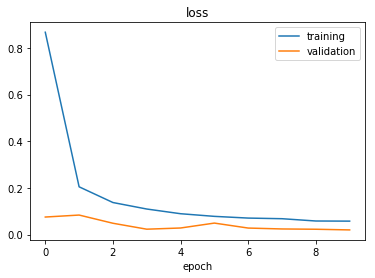

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

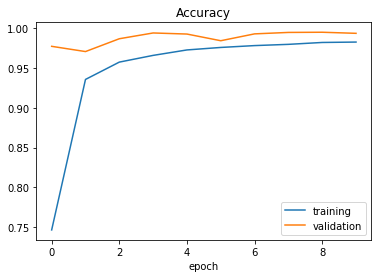

In [115]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [116]:
score = model.evaluate(X_test,y_test,verbose=0)

print('Test Score:',score[0])
print('Test Accuracy:',score[1])

Test Score: 0.10098799464726686
Test Accuracy: 0.9726840854823731


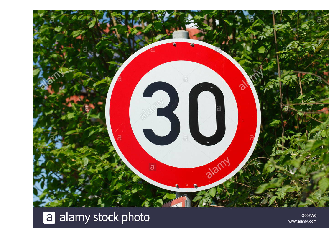

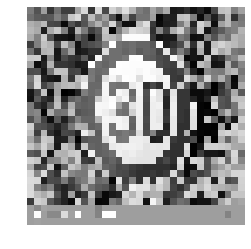

Predicted sign: [1] (Speed limit (30km/h))


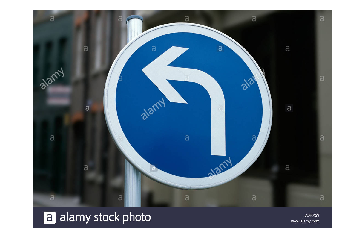

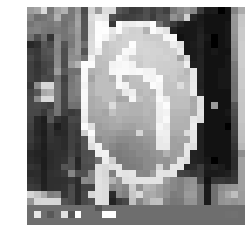

Predicted sign: [12] (Priority road)


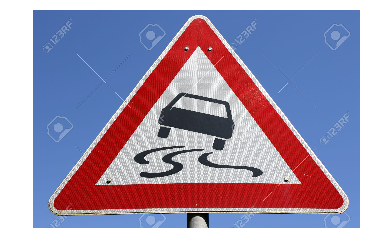

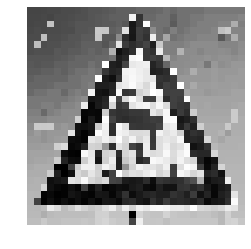

Predicted sign: [23] (Slippery road)


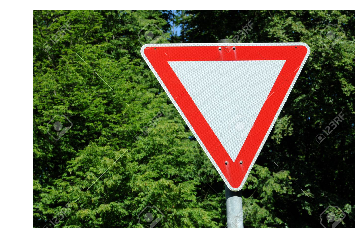

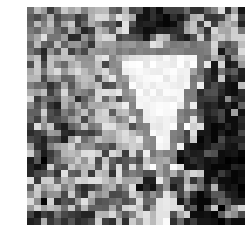

Predicted sign: [13] (Yield)


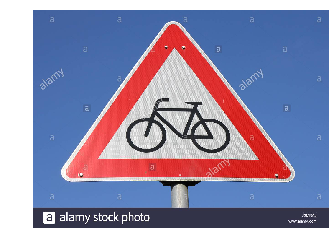

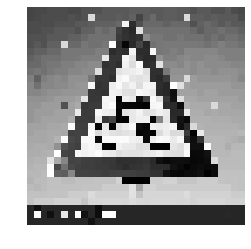

Predicted sign: [29] (Bicycles crossing)


In [144]:
import requests
from PIL import Image
url_list = ['https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg',
           'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
           'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg',
           'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg',
           'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg']

for url in url_list:
  r = requests.get(url, stream=True)
  img = Image.open(r.raw)
  plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.axis('off')
  plt.show()
  img = np.array(img)
  img = cv2.resize(img,(32,32))
  img = preprocess(img)
  plt.imshow(img,cmap=plt.get_cmap('gray'))
  plt.axis('off')
  plt.show()
  img = img.reshape(1,32,32,1)
  print("Predicted sign: "+str(model.predict_classes(img))+" ("+data.loc[data['ClassId'] == model.predict_classes(img)[0]]['SignName'].values[0]+")")

'Speed limit (60km/h)'